<a href="https://colab.research.google.com/github/LuZhang0128/Perspectives/blob/main/README.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
!pip install -U git+http://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git --quiet
!pip install NRCLex --quiet
!pip install -U kaleido --quiet
import pandas as pd
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import wordcloud
import spacy
import gensim
import numpy as np 
import seaborn 
import sklearn.metrics.pairwise 
import sklearn.manifold 
import sklearn.decomposition 
import lucem_illud
import plotly.express as px
from lucem_illud.processing import normalizeTokens, trainTestSplit, word_tokenize, sent_tokenize
from nrclex import NRCLex

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load and Clean Data
Here I've collaborated with my friend and have written a scraper for Twitter data. However, it only randomly send back a certain amount of Tweets per day every time I try to make request through the code. Here for this class project, I just used one output file, and can expand the scale by running the program multiple times. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# read in data from several different requests
df1 = pd.read_csv('/content/drive/MyDrive/Perspectives/data/twitter_info_reply1.csv')
df = df1.drop_duplicates().reset_index(drop=True)

In [ ]:
# remove urls and uninformative information like websites and '@'s
cleaned_text = []
for row in df['m_content']:
    text = str(row)
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\B[@]\S+\b', '', text)
    cleaned_text.append(text)

df['text'] = cleaned_text
df['g_publish_time']= pd.to_datetime(df['g_publish_time'])
df = df.dropna(subset=['text'])

In [ ]:
print(len(df))
df.head()

123517


,m_content,m_content_url,m_content_id,m_images,m_videos,r_comment_num,g_publish_time,r_like_num,r_trans_num,u_id,keyword,in_reply_to_screen_name,in_reply_to_status_id,u_nickname,u_area,screen_name,text
0,http://twitpic.com/gh4w - Wolf-dieter ring #blm,https://twitter.com/jbenno/status/962079197,962079197,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Wolf-dieter ring #blm
1,http://twitpic.com/gh3o - Hier @presseschauer ...,https://twitter.com/jbenno/status/962066767,962066767,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Hier und #blm
2,@furukama the leagel dabate on trust and commu...,https://twitter.com/jbenno/status/962226263,962226263,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,furukama,962226263,Joerg Blumtritt,Abu Dhabi,jbenno,the leagel dabate on trust and communications...
3,http://twitpic.com/gno2 - Noshow-tisch #blm,https://twitter.com/jbenno/status/963782003,963782003,NaN,NaN,0,2008-10-17,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Noshow-tisch #blm
4,http://twitpic.com/gno6 - Buffet #blm,https://twitter.com/jbenno/status/963782458,963782458,NaN,NaN,0,2008-10-17,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Buffet #blm


In [ ]:
# split the data to before the event and after the event
# before is 0 and after is 1
before = []
for i in df.iloc:
  # print(i.g_publish_time)
  # print(i.g_publish_time < pd.to_datetime('2020-05-25'))
  if i.g_publish_time < pd.to_datetime('2020-05-25'):
    before.append(0)
  else:
    before.append(1)

df['target'] = before

In [ ]:
# create tokens for future use
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
df['normalized_text'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [ ]:
df['tokenized_sents'] = df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [normalizeTokens(s) for s in x])

In [ ]:
# save the data
df.to_csv('/content/drive/MyDrive/Perspectives/df.csv')
df.to_pickle('/content/drive/MyDrive/Perspectives/df.pkl')

In [ ]:
# read in the data
df = pd.read_csv('/content/drive/MyDrive/BLM_data/df.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,12,13,14,15,16,17,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Basic Plots

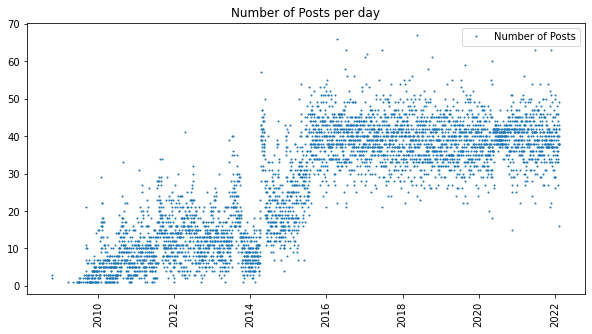

In [ ]:
# number of posts per day
df_gb = df.groupby(['g_publish_time']).size()

plt.figure(figsize=(10,5))
plt.plot(df_gb, 'o',label="Number of Posts", markersize=1, linewidth=0.1)
plt.xticks(rotation=90)
plt.title("Number of Posts per day")
plt.legend()
plt.show()

## Word Cloud

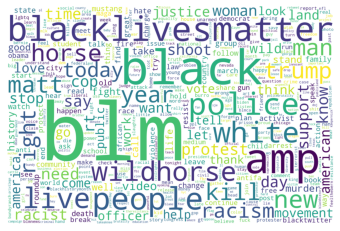

In [ ]:
# overall word cloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets.pdf", format = 'pdf')

In [ ]:
# create seperate dataset for before and after the event
df_before = df[df["target"]==0]
df_after = df[df["target"]==1]

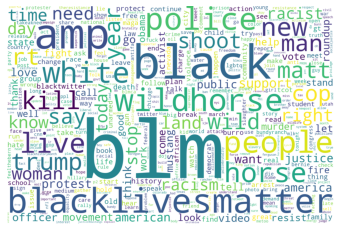

In [ ]:
# word cloud before the event
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df_before['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets before 2020-05-25.pdf", format = 'pdf')

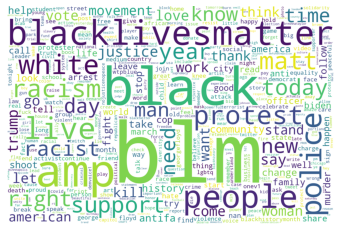

In [ ]:
# word cloud after the event
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df_after['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets after 2020-05-25.pdf", format = 'pdf')

## Emotion Classification Before and After the Event

Emotion classification for all tweets

In [60]:
# train word to vec models both before and after the event
# https://medium.com/geekculture/simple-emotion-classification-in-python-40fb24692541
str_tweet = ','.join(df['text'])
text_object = NRCLex(str_tweet)

In [61]:
# get the raw score based on a dictionary-based algorithm
data = text_object.raw_emotion_scores

In [62]:
# plot
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)

fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

Emotion classification before the event

In [ ]:
str_tweet_before = ','.join(df_before['text'])
text_object = NRCLex(str_tweet_before)

data = text_object.raw_emotion_scores

# plot
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
emotion_df['Emotion Percentage'] = emotion_df['Emotion Count']/len(str_tweet_before)

fig = px.bar(emotion_df, x='Emotion Percentage', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

Emotion classification after the event

In [ ]:
str_tweet_after = ','.join(df_after['text'])
text_object = NRCLex(str_tweet_after)

data = text_object.raw_emotion_scores

# plot
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
emotion_df['Emotion Percentage'] = emotion_df['Emotion Count']/len(str_tweet_after)

fig = px.bar(emotion_df, x='Emotion Percentage', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()